## Importando Bibliotecas e Dependências

In [1]:
# Importação de bibliotecas externas necessárias
import sys
import os
sys.path.append(os.path.abspath("../..")) 


import logging
from Modules.Models import *
from Modules.Methods import *

In [2]:
logging.basicConfig(
    filename="../../Outputs/GRN5_CMAES_execution.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)

C:\Users\anabi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  warn("The following arguments have no effect for a chosen solver: {}."


{'best_ind': Individual(fitness=inf, coeffs={'A': {'E': {'n': val=0.1, 'k': val=0.1, '-': True}, 'tau': val=5.0}, 'B': {'A': {'n': val=1.2494616818778805, 'k': val=0.1, '-': False}, 'tau': val=0.1}, 'C': {'B': {'n': val=18.672872787697433, 'k': val=2.0, '-': False}, 'tau': val=5.0}, 'D': {'C': {'n': val=14.867244374407711, 'k': val=0.5635320311706451, '-': False}, 'tau': val=0.1}, 'E': {'D': {'n': val=10.683261455632923, 'k': val=2.0, '-': False}, 'B': {'n': val=27.93129714595187, 'k': val=2.0, '-': False}, 'E': {'n': val=10.293519422107352, 'k': val=2.0, '-': False}, 'tau': val=3.9117476087779175}}, ind_size=19),
 'error_type': 'SQUARED',
 'solver': 'RK45',
 'seed': None,
 'ABS_Fitness': 169.75097743107472,
 'SQUARED_Fitness': 12.512849731526954,
 'MSE_Fitness': 0.6262856336150966,
 'MABS_Fitness': 0.6790039097242989,
 'execution_time': 3.86147141456604}

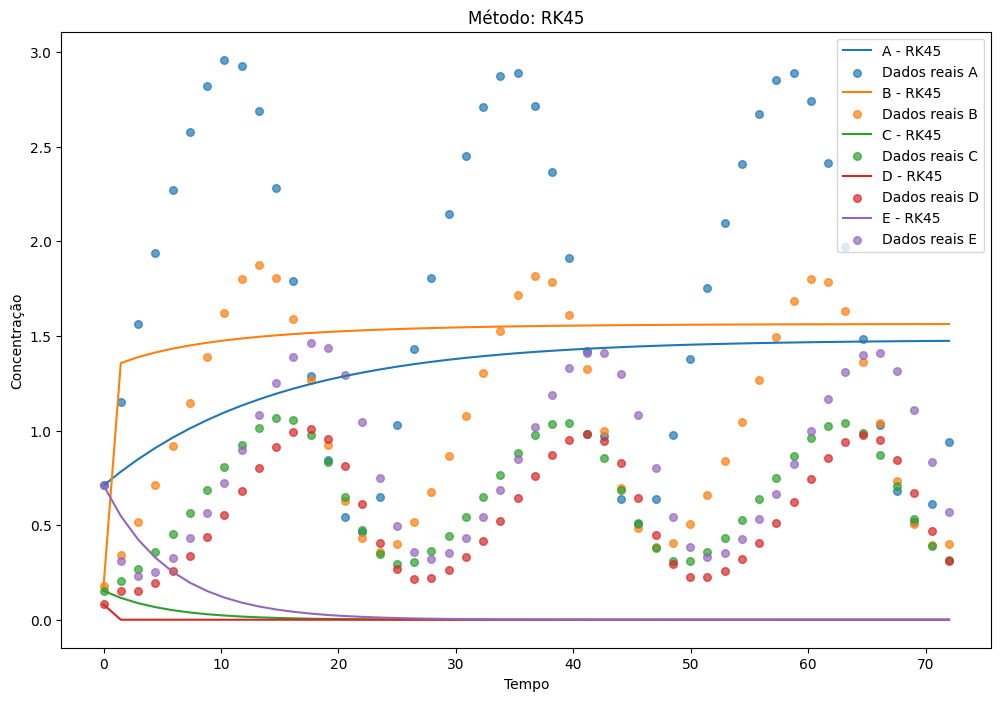

In [3]:
#INICIALIZANDO MODELO
GRN5 = ModelWrapper.GRN5()
CMAES = CMAES(model=GRN5)
results = CMAES.run(gens=10, logging=logging, verbose=True, filepath="../../Outputs/")
results